In [1]:
# Import required libraries
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu126
CUDA available: True


## 1. Define Generator Architecture

We need to define the same generator architecture used during training.

In [2]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, base_channel):
        super(Generator, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.base_channel = base_channel
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(in_channels, base_channel * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_channel * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 8, base_channel * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 4, base_channel * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 2, base_channel, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, base_channel, 3, 1, 0, dilation=2, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, out_channels, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.conv_blocks(z)

# Hyperparameters (must match training)
latent_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


## 2. Function to Load Model and Generate Images

In [3]:
def load_generator_and_sample(model_path, num_samples=25, seed=42):
    """
    Load a generator model and generate sample images.
    
    Args:
        model_path: Path to the saved generator model
        num_samples: Number of images to generate
        seed: Random seed for reproducibility
    
    Returns:
        generated_images: Tensor of generated images
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Initialize generator
    generator = Generator(latent_dim, 1, 128).to(device)
    
    # Load saved weights
    if os.path.exists(model_path):
        generator.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from: {model_path}")
    else:
        print(f"Warning: Model file not found at {model_path}")
        print("Using randomly initialized generator (untrained)")
    
    # Set to evaluation mode
    generator.eval()
    
    # Generate images
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, 1, 1).to(device)
        generated_images = generator(noise)
    
    return generated_images.cpu()

def display_images(images, title, save_path=None):
    """
    Display a grid of images.
    
    Args:
        images: Tensor of images to display
        title: Title for the plot
        save_path: Optional path to save the figure
    """
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    grid = make_grid(images, nrow=5, padding=2, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

print("Helper functions defined successfully!")

Helper functions defined successfully!


## 3. Sample Images at Start of Training

At the beginning of training, the generator produces random noise that doesn't resemble MNIST digits.

Model loaded from: ./models/G_epoch_0_batch_0.pth


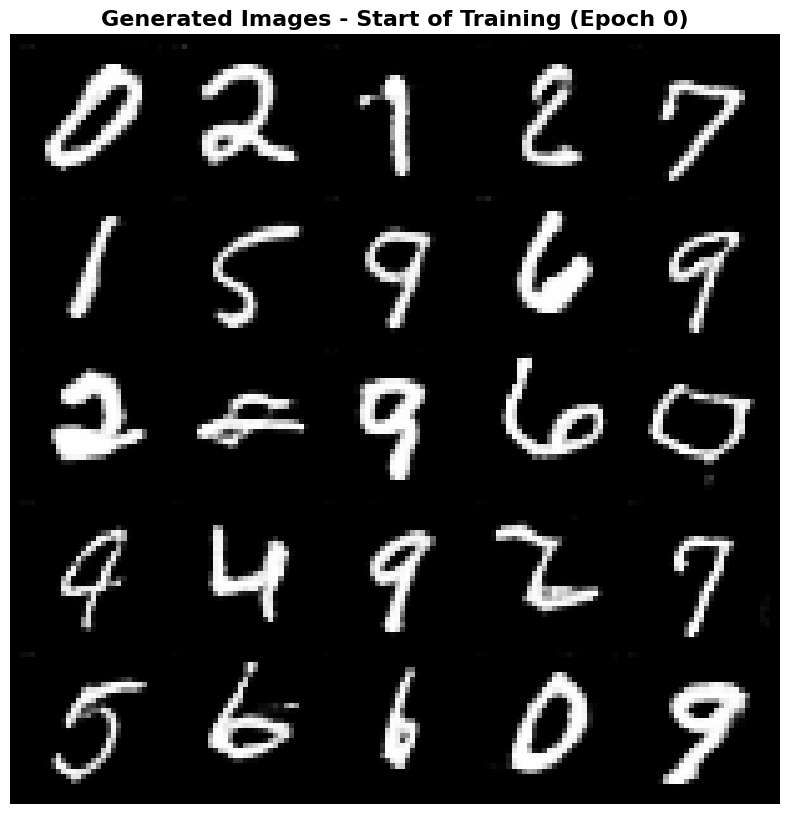


Observation: At the start of training, the generator produces random noise-like patterns.


In [4]:
# Path to early training checkpoint (e.g., epoch 0 or after few batches)
# You may need to adjust this path based on your saved models
early_model_path = './models/G_epoch_0_batch_0.pth'

# If specific early checkpoint doesn't exist, we'll show what untrained generator produces
if not os.path.exists(early_model_path):
    print("Early checkpoint not found. Using randomly initialized generator.")
    # Create a random generator to show initial state
    generator_early = Generator(latent_dim, 1, 128).to(device)
    generator_early.eval()
    with torch.no_grad():
        noise = torch.randn(25, latent_dim, 1, 1).to(device)
        early_images = generator_early(noise).cpu()
else:
    early_images = load_generator_and_sample(early_model_path, num_samples=25)

display_images(
    early_images,
    "Generated Images - Start of Training (Epoch 0)",
    save_path='./images/task2_start_training.png'
)

print("\nObservation: At the start of training, the generator produces random noise-like patterns.")

## 4. Sample Images Halfway Through Training

Halfway through training, the generator starts to produce recognizable digit-like shapes, though they may still be blurry.

Using available checkpoint: ./models\G_epoch_32_batch_30000.pth
Model loaded from: ./models\G_epoch_32_batch_30000.pth


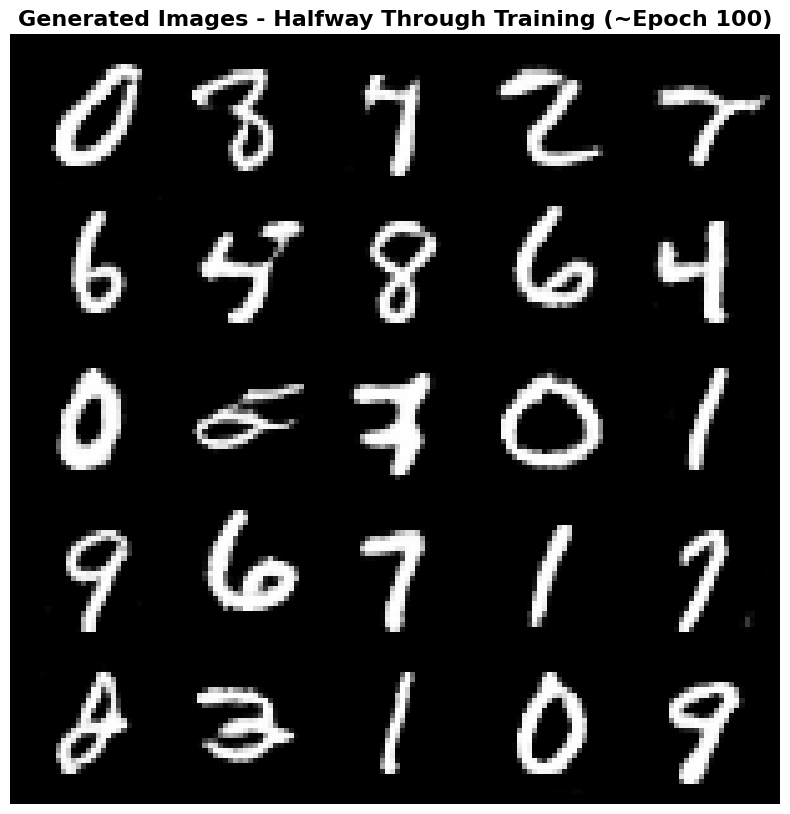


Observation: Halfway through training, digit-like shapes begin to emerge.


In [5]:
# Path to mid-training checkpoint (e.g., epoch 100 for 200 total epochs)
# You may need to adjust this path based on your saved models
# Look for models saved around epoch 100

# Try to find a middle checkpoint
mid_model_paths = [
    './models/G_epoch_100_batch_15600.pth',
    './models/G_epoch_99_batch_15500.pth',
    './models/generator_mid_training.pth'
]

mid_model_path = None
for path in mid_model_paths:
    if os.path.exists(path):
        mid_model_path = path
        break

if mid_model_path is None:
    # If no mid checkpoint exists, look for any checkpoint in models directory
    if os.path.exists('./models'):
        model_files = [f for f in os.listdir('./models') if f.startswith('G_') and f.endswith('.pth')]
        if model_files:
            # Sort by filename and pick the middle one
            model_files.sort()
            mid_idx = len(model_files) // 2
            mid_model_path = os.path.join('./models', model_files[mid_idx])
            print(f"Using available checkpoint: {mid_model_path}")

if mid_model_path and os.path.exists(mid_model_path):
    mid_images = load_generator_and_sample(mid_model_path, num_samples=25)
    display_images(
        mid_images,
        "Generated Images - Halfway Through Training (~Epoch 100)",
        save_path='./images/task2_mid_training.png'
    )
    print("\nObservation: Halfway through training, digit-like shapes begin to emerge.")
else:
    print("No mid-training checkpoint found. Please train the model first or specify the correct path.")

## 5. Sample Images After Training Terminates

After full training, the generator produces clear, realistic MNIST digits.

Model loaded from: ./models/generator_final.pth


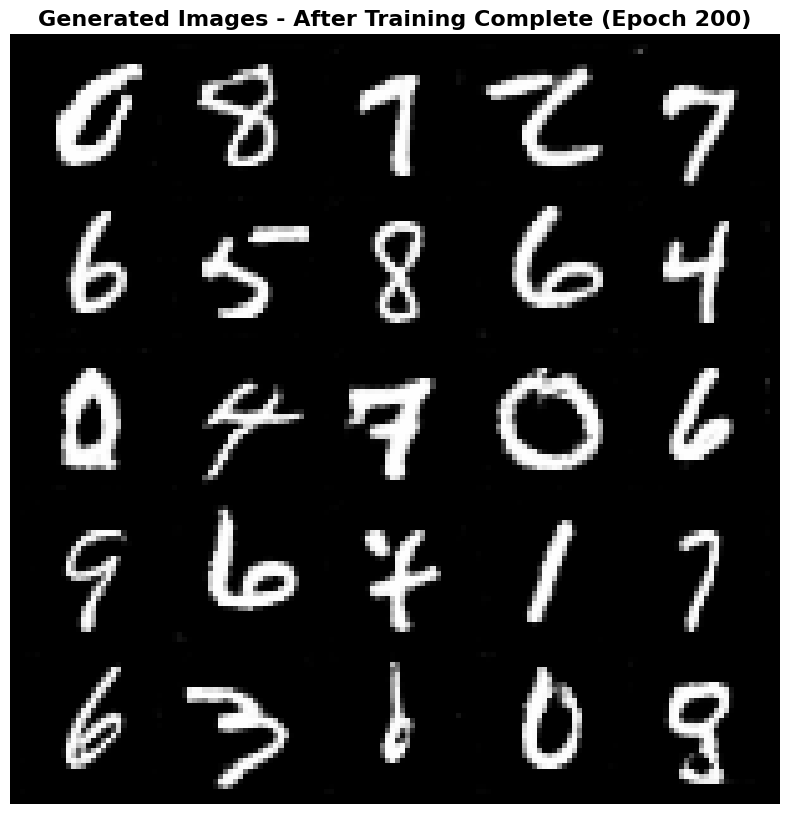


Observation: After complete training, the generator produces clear, realistic MNIST digits.


In [6]:
# Path to final trained model
final_model_path = './models/generator_final.pth'

# If final model doesn't exist, try to find the latest checkpoint
if not os.path.exists(final_model_path):
    if os.path.exists('./models'):
        model_files = [f for f in os.listdir('./models') if f.startswith('G_') and f.endswith('.pth')]
        if model_files:
            # Sort and pick the last one
            model_files.sort()
            final_model_path = os.path.join('./models', model_files[-1])
            print(f"Using latest checkpoint: {final_model_path}")

if os.path.exists(final_model_path):
    final_images = load_generator_and_sample(final_model_path, num_samples=25)
    display_images(
        final_images,
        "Generated Images - After Training Complete (Epoch 200)",
        save_path='./images/task2_final_training.png'
    )
    print("\nObservation: After complete training, the generator produces clear, realistic MNIST digits.")
else:
    print("No final checkpoint found. Please train the model first or specify the correct path.")

## 6. Side-by-Side Comparison

Let's display all three stages side by side for easy comparison.

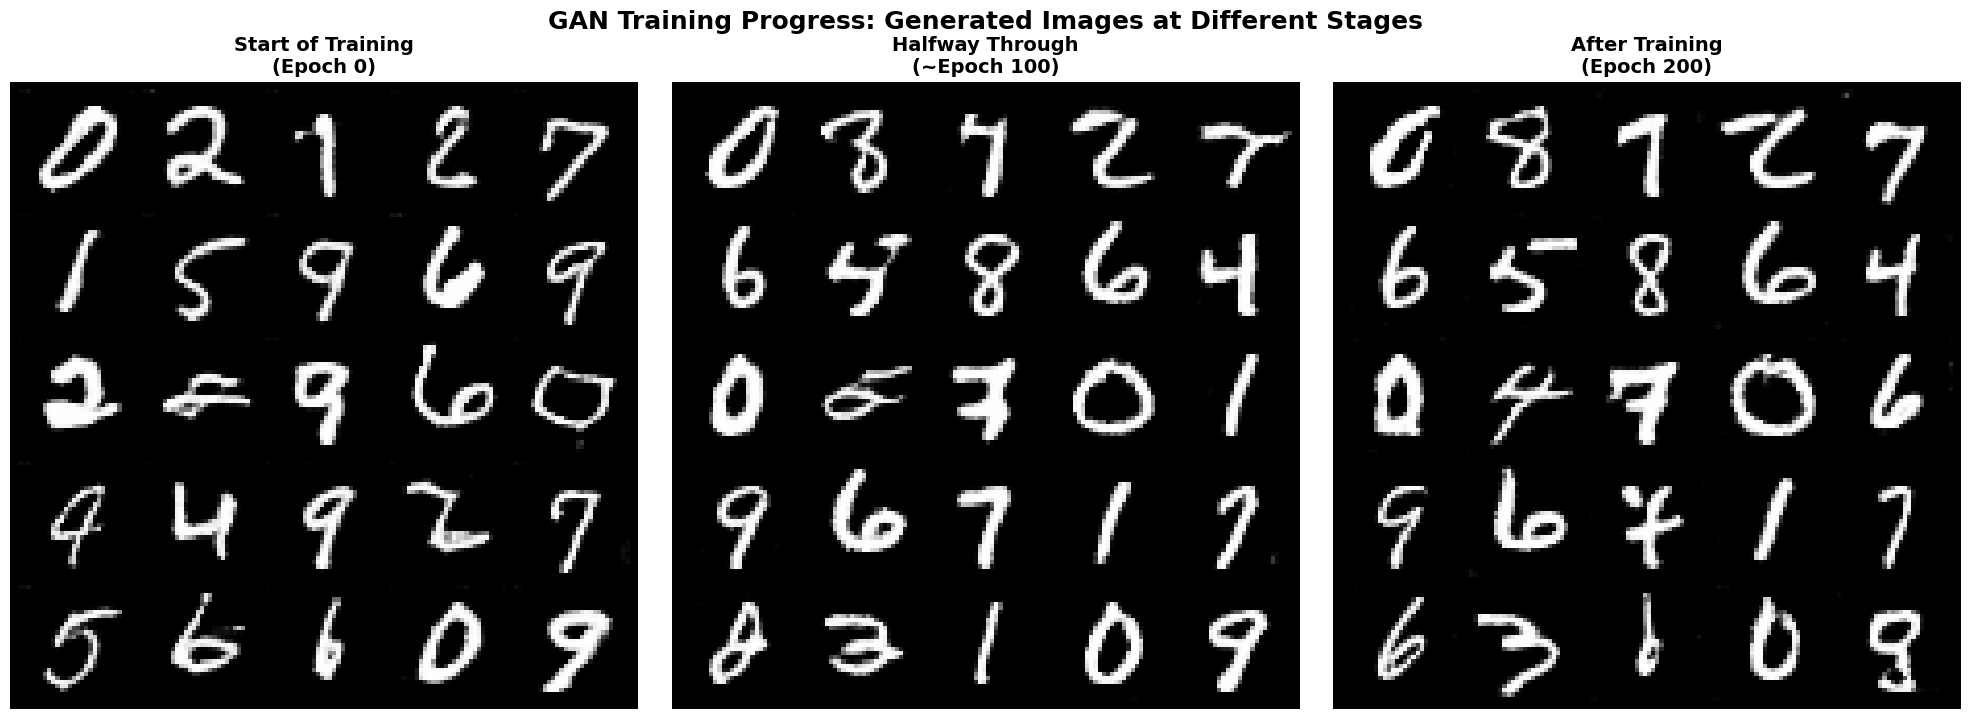


Task 2 Complete!

Key Observations:
1. START: Generator produces random noise with no recognizable patterns
2. MIDDLE: Digit-like shapes emerge, but images are still blurry and imperfect
3. END: Clear, realistic MNIST digits that closely resemble the training data

This demonstrates the adversarial learning process where the generator
progressively learns to create more realistic images to fool the discriminator.


In [7]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

stages = [
    (early_images if 'early_images' in locals() else None, "Start of Training\n(Epoch 0)"),
    (mid_images if 'mid_images' in locals() else None, "Halfway Through\n(~Epoch 100)"),
    (final_images if 'final_images' in locals() else None, "After Training\n(Epoch 200)")
]

for idx, (images, title) in enumerate(stages):
    if images is not None:
        grid = make_grid(images, nrow=5, padding=2, normalize=True)
        axes[idx].imshow(np.transpose(grid, (1, 2, 0)))
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No images available', 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('GAN Training Progress: Generated Images at Different Stages', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./images/task2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Task 2 Complete!")
print("="*80)
print("\nKey Observations:")
print("1. START: Generator produces random noise with no recognizable patterns")
print("2. MIDDLE: Digit-like shapes emerge, but images are still blurry and imperfect")
print("3. END: Clear, realistic MNIST digits that closely resemble the training data")
print("\nThis demonstrates the adversarial learning process where the generator")
print("progressively learns to create more realistic images to fool the discriminator.")

## 7. Generate Additional Samples from Final Model

Let's generate a few more batches to show the diversity of the trained generator.

Model loaded from: ./models/generator_final.pth
Model loaded from: ./models/generator_final.pth
Model loaded from: ./models/generator_final.pth


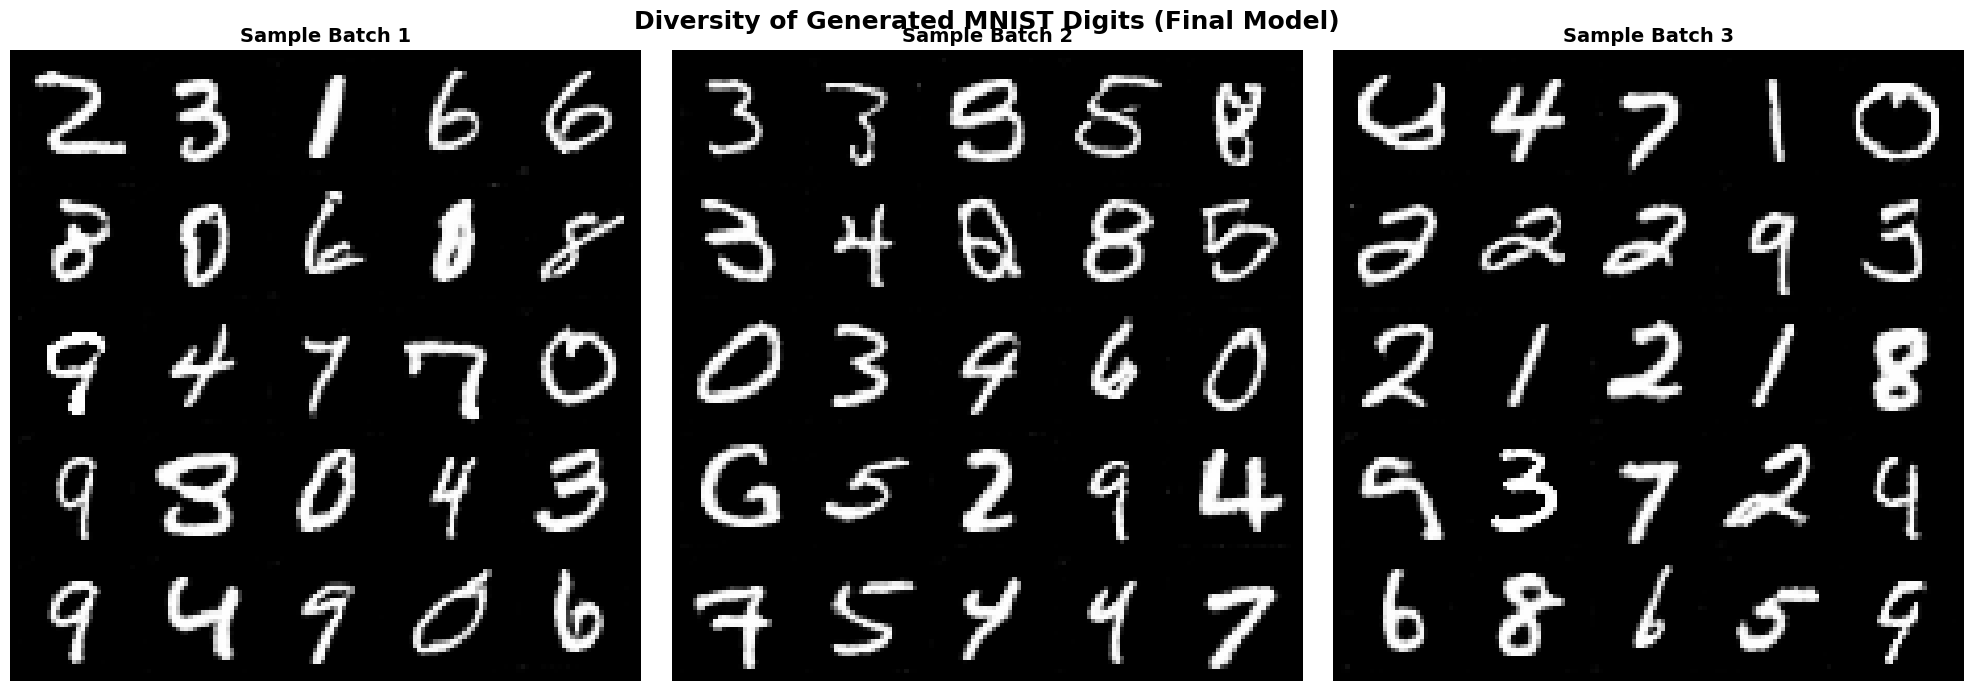


The trained GAN can generate diverse, realistic MNIST digits!


In [8]:
if 'final_model_path' in locals() and os.path.exists(final_model_path):
    # Generate 3 different batches with different seeds
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    for i in range(3):
        batch_images = load_generator_and_sample(final_model_path, num_samples=25, seed=100+i)
        grid = make_grid(batch_images, nrow=5, padding=2, normalize=True)
        axes[i].imshow(np.transpose(grid, (1, 2, 0)))
        axes[i].set_title(f"Sample Batch {i+1}", fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Diversity of Generated MNIST Digits (Final Model)', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('./images/task2_diversity.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nThe trained GAN can generate diverse, realistic MNIST digits!")
else:
    print("Final model not available. Please train the model first.")

## Notes

**Important:** To run this notebook successfully, you need to:
1. First run Task 1 notebook to train the GAN
2. Ensure model checkpoints are saved in the `./models/` directory
3. The notebook will automatically find available checkpoints

**Model Checkpoint Naming:**
- Early: `G_epoch_0_batch_0.pth` or similar
- Mid: `G_epoch_100_batch_XXXX.pth` or similar
- Final: `generator_final.pth`

If specific checkpoints are not found, the notebook will attempt to use available checkpoints.